In [61]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from dataset_tools import MNIST

cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [62]:
flatten = lambda x: ToTensor()(x).view(-1)

# data_train = MNIST(train=True, transform=ToTensor())
# data_test = MNIST(train=False, transform=ToTensor())
data_train = MNIST(train=True, transform=flatten)
data_test = MNIST(train=False, transform=flatten)

train_loader = DataLoader(data_train, batch_size=64, shuffle=True, pin_memory=cuda)
test_loader = DataLoader(data_test, batch_size=64, shuffle=True, pin_memory=cuda)




In [36]:
# test how a sample looks
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 784]) torch.Size([64])


# Autoencoder

In [37]:

class AutoEncoder(nn.Module):
    def __init__(self, latent_features=3):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_features, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    


In [38]:
model = AutoEncoder()
print(model)

if cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [39]:
# test forward pass
x, y = next(iter(train_loader))
print("x.shape:", x.shape)

if cuda:
    x = x.cuda()

output = model(x)

print("output.shape:", output.shape)

x.shape: torch.Size([64, 784])
output.shape: torch.Size([64, 784])


## Training

In [40]:
num_epochs = 10

train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, x)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    train_loss.append(np.mean(batch_loss))

    print(f"Epoch {epoch+1}, loss: {np.mean(batch_loss)}")




Epoch 1, loss: 0.05953785583281568
Epoch 2, loss: 0.04299414631670345
Epoch 3, loss: 0.03948509045191474
Epoch 4, loss: 0.03798329317247245
Epoch 5, loss: 0.036952585172551525
Epoch 6, loss: 0.036105473398733365
Epoch 7, loss: 0.03539478069524775
Epoch 8, loss: 0.03481564434694011
Epoch 9, loss: 0.034348405361461484
Epoch 10, loss: 0.03395687699762743


output.shape: torch.Size([64, 784])


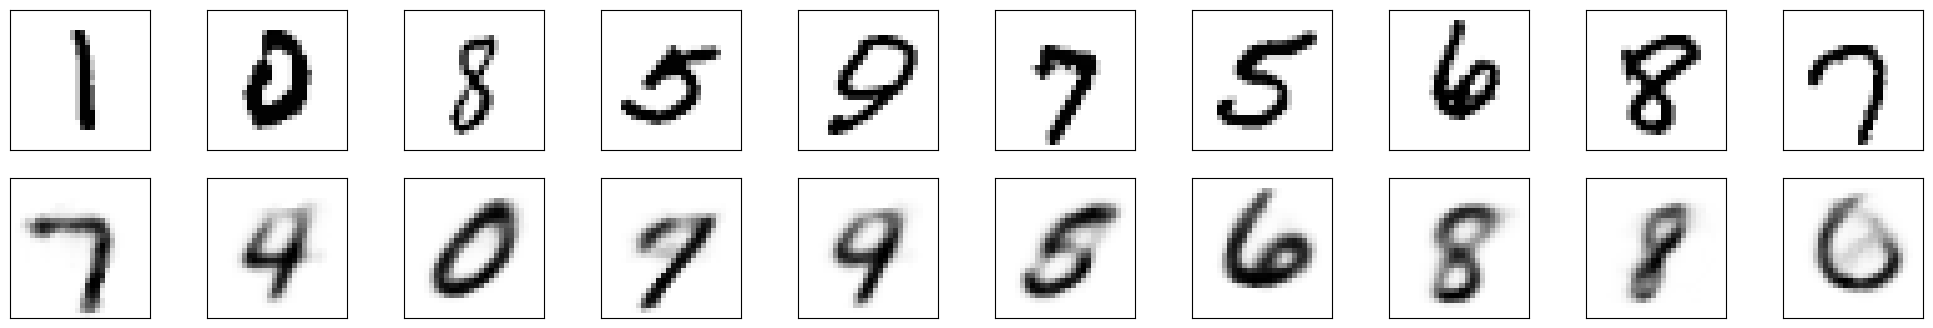

In [41]:
# test the model
model.eval()

images, labels = next(iter(test_loader))
if cuda:
    images = images.cuda()
output = model(images)

print("output.shape:", output.shape)

# plot the original and reconstructed images

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for images, row in zip([x, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.view(28, 28).cpu().detach().numpy(), cmap='Greys')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()


